# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [177]:
# These libraries may be useful to you

# !pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.


ERROR: Could not find a version that satisfies the requirement pyLDAvis.sklearn (from versions: none)
ERROR: No matching distribution found for pyLDAvis.sklearn


In [180]:
# You also need a Python version => 3.9.0
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

In [182]:
# add any additional libaries you need here
import nltk
nltk.download('brown')

nlp = spacy.load('en_core_web_sm')

import re
from string import punctuation
from pprintpp import pprint

import pyLDAvis.lda_model
pyLDAvis.lda_model.prepare

[nltk_data] Downloading package brown to /Users/dunya/nltk_data...
[nltk_data]   Package brown is already up-to-date!


<function pyLDAvis.lda_model.prepare(lda_model, dtm, vectorizer, **kwargs)>

In [183]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [184]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in hobbies, editorial, government, news, and romance.

In [185]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category):
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

display(df)

,category,id,text
0,editorial,cb01,Assembly session brought much good The General...
1,editorial,cb02,Must Berlin remain divided ? ? The inference h...
2,editorial,cb03,"A good man departs . Goodby , Mr. Sam . Sam Ra..."
3,editorial,cb04,A shock wave from Africa Word of Dag Hammarskj...
4,editorial,cb05,Help when needed If the Dominican Republic ach...
...,...,...,...
161,hobbies,ce32,"Throughout history , the man who showed superi..."
162,hobbies,ce33,Sixty miles north of New York City where the w...
163,hobbies,ce34,"In the period since the end of World War 2 , -..."
164,hobbies,ce35,New rule no. 2 : : Don't build from the outsid...


In [186]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))

display(df)


,category,id,text,char_len,word_len
0,editorial,cb01,Assembly session brought much good The General...,12659,2200
1,editorial,cb02,Must Berlin remain divided ? ? The inference h...,12544,2234
2,editorial,cb03,"A good man departs . Goodby , Mr. Sam . Sam Ra...",11871,2244
3,editorial,cb04,A shock wave from Africa Word of Dag Hammarskj...,12284,2230
4,editorial,cb05,Help when needed If the Dominican Republic ach...,12479,2241
...,...,...,...,...,...
161,hobbies,ce32,"Throughout history , the man who showed superi...",13629,2339
162,hobbies,ce33,Sixty miles north of New York City where the w...,11845,2233
163,hobbies,ce34,"In the period since the end of World War 2 , -...",13029,2300
164,hobbies,ce35,New rule no. 2 : : Don't build from the outsid...,11800,2272


<AxesSubplot:xlabel='category'>

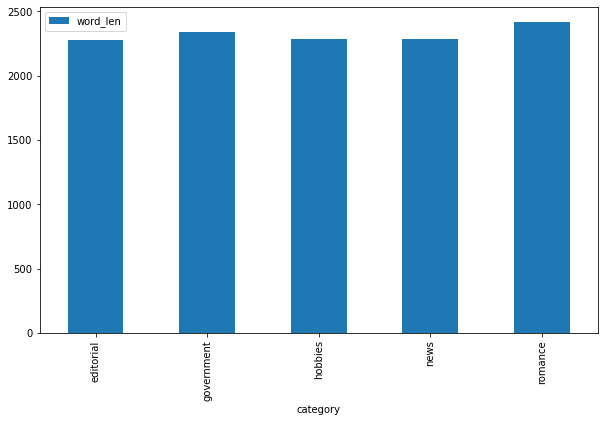

In [187]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [188]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

/Users/dunya/opt/miniconda3/envs/ADS500B/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [189]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

In [190]:
display(count_text_vectors)

<166x4941 sparse matrix of type '<class 'numpy.int64'>'
	with 72541 stored elements in Compressed Sparse Row format>

In [191]:
display(tfidf_text_vectors)

<166x4941 sparse matrix of type '<class 'numpy.float64'>'
	with 72541 stored elements in Compressed Sparse Row format>

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: The count vector transformed the texts of the 5 different categories into a vector based on the word occurences in the entire text. The TF-IDF vector transformed the same texts into vectors using weighted calculations of word frequencies, creating a vector based on word importance. This resulted in 72,541 elements in both the `tfidf_text_vectors` and `count_text_vectors`.



## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [192]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

/Users/dunya/opt/miniconda3/envs/ADS500B/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [193]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.40)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.64)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.01)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. 

For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [194]:
# Compare the NMF Factorization to original categories

uniq = df['category'].unique()
print("Original Categories: \n", uniq)

# Separate DFs by category to make separate tallys

edit_df = df[df['category'] == 'editorial']
govt_df = df[df['category'] == 'government']
news_df = df[df['category'] == 'news']
roma_df = df[df['category'] == 'romance']
hobb_df = df[df['category'] == 'hobbies']

Original Categories: 
 ['editorial' 'government' 'news' 'romance' 'hobbies']


In [195]:
punct = set(punctuation)

# Helpers

def remove_stop(tokens) :
    stop_words = spacy.lang.en.STOP_WORDS
    removed = [w for w in tokens if not w in stop_words]
    return(removed)

def remove_punctuation(text, punct_set=punct) :
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text):
    collapse_whitespace = re.compile(r'\s+')
    return([item.lower() for item in collapse_whitespace.split(text)])

def prepare(text, pipeline) : 
    tokens = str(text)
    for transform in pipeline : 
        tokens = transform(tokens)
    return(tokens)

# Create pipeline

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop] 

# Helper to convert word count list to dictionary

def convert_to_dictionary(tup, di):
    di = dict(tup)
    return di
     


In [196]:
# Make tokens

edit_df['tokens'] = edit_df['text'].apply(prepare,pipeline = my_pipeline)
govt_df['tokens'] = govt_df["text"].apply(prepare,pipeline = my_pipeline)
news_df['tokens'] = news_df["text"].apply(prepare,pipeline = my_pipeline)
roma_df['tokens'] = roma_df["text"].apply(prepare,pipeline = my_pipeline)
hobb_df['tokens'] = hobb_df["text"].apply(prepare,pipeline = my_pipeline)

/var/folders/t6/cjn4y6mx6lj46_h4_hhsk7740000gn/T/ipykernel_86154/1335999652.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edit_df['tokens'] = edit_df['text'].apply(prepare,pipeline = my_pipeline)
/var/folders/t6/cjn4y6mx6lj46_h4_hhsk7740000gn/T/ipykernel_86154/1335999652.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  govt_df['tokens'] = govt_df["text"].apply(prepare,pipeline = my_pipeline)
/var/folders/t6/cjn4y6mx6lj46_h4_hhsk7740000gn/T/ipykernel_86154/1335999652.py:5: SettingWithCopyWarning: 
A

In [197]:
# Helper to create dictionary of term counts for tokens in df

def create_word_dict(df):
    # Step 1: Aggregate dfs token lists
    tokens = np.concatenate( df['tokens'].to_list() , axis=0 )
    print("Total tokens: ", len(tokens))
    # Step 2: Get word counts
    word_list = Counter(tokens).most_common()
    # Step 3: Convert word count list to dictionary
    empty = {}
    word_dict = convert_to_dictionary(word_list, empty)

    # pprint(word_dict)
    return word_dict

In [198]:
edit_dict = create_word_dict(edit_df)
govt_dict = create_word_dict(govt_df)
news_dict = create_word_dict(news_df)
roma_dict = create_word_dict(roma_df)
hobb_dict = create_word_dict(hobb_df)

# display(df)

Total tokens:  26189
Total tokens:  32159
Total tokens:  47589
Total tokens:  25504
Total tokens:  36399


In [199]:
def disp_something(model, features, no_top_words=5):
    json = dict()
    for topic, words in enumerate(model.components_):
        ret = list()
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            ret.append(features[largest[i]])
        json[topic] = ret
    return json
        


In [200]:
topics = disp_something(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())
pprint(topics)

{
    0: ['mr', 'president', 'kennedy', 'united', 'khrushchev'],
    1: ['said', 'didn', 'll', 'thought', 'man'],
    2: ['state', 'development', 'tax', 'sales', 'program'],
    3: ['mrs', 'mr', 'said', 'miss', 'car'],
    4: ['game', 'league', 'ball', 'baseball', 'team'],
}


### For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [201]:
bet_dict = list()

words, edits, govts = list(), list(), list()
romas, news, hobbs = list(), list(), list()

for i in topics:
    for word in topics[i]:
        exec('try:e_count = edit_dict[word]\nexcept:e_count = None')
        exec('try:g_count = govt_dict[word]\nexcept:g_count = None')
        exec('try:n_count = news_dict[word]\nexcept:n_count = None')
        exec('try:r_count = roma_dict[word]\nexcept:r_count = None')
        exec('try:h_count = hobb_dict[word]\nexcept:h_count = None')
        words.append(word)
        edits.append(e_count)
        govts.append(g_count)
        news.append(n_count)
        romas.append(r_count)
        hobbs.append(h_count)

tallied_df = pd.DataFrame({
    "WORD": words, "EDIT": edits, "GOVT": govts,
    "NEWS": news, "ROMA": romas, "HOBB": hobbs})

# display(tallied_df)

In [202]:
# Separate topics in df

topic_00_df = tallied_df[0:5]
topic_01_df = tallied_df[5:10]
topic_02_df = tallied_df[10:15]
topic_03_df = tallied_df[15:20]
topic_04_df = tallied_df[20:25]

#### Topic 00 Interpretation

In [203]:
print("Editorial Count: ", topic_00_df["EDIT"].sum())
print("News Count: ", topic_00_df["NEWS"].sum())
display(topic_00_df)

Editorial Count:  326.0
News Count:  461.0


,WORD,EDIT,GOVT,NEWS,ROMA,HOBB
0,mr,110.0,65.0,170.0,33.0,21.0
1,president,58.0,48.0,142.0,10.0,9.0
2,kennedy,39.0,4.0,66.0,NaN,1.0
3,united,82.0,155.0,58.0,3.0,15.0
4,khrushchev,37.0,NaN,25.0,NaN,NaN


Given the tallied words in the original Brown categories, the categories with NaN values can readily be excluded. That said, topic_00 definitely does not fall under the Government, Romance, and Hobbies categories. This leaves Editorial and News as possible categories for topic_00. The News category references the top 3 terms more than Editorial and the overall term counts of the top 5 words in News 41% more frequently.

#### Topic 01 Interpretation

In [204]:
print("Editorial Count: ", topic_01_df["EDIT"].sum())
print("News Count: ", topic_01_df["NEWS"].sum())
print("Government Count: ", topic_01_df["GOVT"].sum())
print("Romance Count: ", topic_01_df["ROMA"].sum())
print("Hobbies Count: ", topic_01_df["HOBB"].sum())
display(topic_01_df)

Editorial Count:  113.0
News Count:  495.0
Government Count:  37.0
Romance Count:  537.0
Hobbies Count:  40.0


,WORD,EDIT,GOVT,NEWS,ROMA,HOBB
5,said,52.0,18.0,406.0,331.0,11.0
6,didn,NaN,NaN,NaN,NaN,NaN
7,ll,NaN,NaN,NaN,NaN,NaN
8,thought,5.0,7.0,15.0,106.0,10.0
9,man,56.0,12.0,74.0,100.0,19.0


Given the tallied words in the original Brown categories, the categories with NaN values should be readily excluded as well. However, the words "didn" and "ll" are NaN among all categories. This means that the tokenization did not account for those terms. Based on the remaining 3 words, the Romance category has a higher frequency, with News being a close second. It is likely topic 01 belongs to the Romance category.

#### Topic 02 Interpretation

In [205]:
print("Editorial Count: ", topic_02_df["EDIT"].sum())
print("News Count: ", topic_02_df["NEWS"].sum())
print("Government Count: ", topic_02_df["GOVT"].sum())
display(topic_02_df)

Editorial Count:  158.0
News Count:  348.0
Government Count:  534.0


,WORD,EDIT,GOVT,NEWS,ROMA,HOBB
10,state,69.0,196.0,153.0,3.0,20.0
11,development,21.0,125.0,19.0,NaN,43.0
12,tax,22.0,90.0,58.0,1.0,NaN
13,sales,4.0,36.0,52.0,4.0,24.0
14,program,42.0,87.0,66.0,NaN,44.0


Using the same logic of excluding NaN values, we can infer topic_02 does not belong to the Romance and Hobbies categories. Based on the total frequency of Editorial, Government, and News, it is likely topic_02 belongs to the Government category.

#### Topic 03 Interpretation

In [206]:
print("Editorial Count: ", topic_03_df["EDIT"].sum())
print("News Count: ", topic_03_df["NEWS"].sum())
print("Romance Count: ", topic_03_df["ROMA"].sum())
print("Hobbies Count: ", topic_03_df["HOBB"].sum())
display(topic_03_df)

Editorial Count:  185.0
News Count:  932.0
Romance Count:  451.0
Hobbies Count:  89.0


,WORD,EDIT,GOVT,NEWS,ROMA,HOBB
15,mrs,9.0,NaN,254.0,39.0,10.0
16,mr,110.0,65.0,170.0,33.0,21.0
17,said,52.0,18.0,406.0,331.0,11.0
18,miss,1.0,7.0,52.0,28.0,9.0
19,car,13.0,3.0,50.0,20.0,38.0


The NaN values in Government excludes the category from consideration. News has the most frequency by a long shot, nearly doubling the runner-up (Romance). It is likely News represents topic_03.

#### Topic 04 Interpretation

In [207]:
print("Editorial Count: ", topic_04_df["EDIT"].sum())
print("News Count: ", topic_04_df["NEWS"].sum())
print("Romance Count: ", topic_04_df["ROMA"].sum())
print("Hobbies Count: ", topic_04_df["HOBB"].sum())
display(topic_04_df)

Editorial Count:  27.0
News Count:  185.0
Romance Count:  43.0
Hobbies Count:  21.0


,WORD,EDIT,GOVT,NEWS,ROMA,HOBB
20,game,6.0,2.0,51.0,9.0,10.0
21,league,9.0,NaN,37.0,6.0,1.0
22,ball,4.0,NaN,37.0,18.0,NaN
23,baseball,3.0,NaN,27.0,4.0,2.0
24,team,5.0,1.0,33.0,6.0,8.0


The NaNs are most prominent in Government and surprisingly appear once in Hobbies, which I thought would have the most sports terminology. News has the largest frequency based on the tallies. It is possible the tokenization of the term "ball" was improperly handled. Based on the tallies, Hobbies is least likely after Government to incorporate this, but this topic is unlikely to belong to News given the other tallied terms analyzed. Its possible that Hobbies is more diverse in terminology than the other categories. More work would need to be done to understand which category topic_04 belongs to.

Q: How does your five-topic NMF model compare to the original Brown categories? 

A: 

The original Brown categories were: (1) editorial, (2) government, (3) news, (4) romance, and (5) hobbies. 

Topic 00 mostly includes presidential terms, as well as a reference to the former leader of the Soviet Union. Based on those terms, it is likely the topic is the editorial category. Topic 04 includes sports terminology, its likely that the topic belongs to the hobbies category. Topic 02 includes the words "state", "development", "tax", "sales", and "program" which are likely to represent the government category. Although editorial may also be a potential category, the Soviet reference in Topic 00 is a more favorable option for it. 

Topic 01 and 03 seemed very similar at first and harder to discern between romance and news, mostly due to the word "said". The frequency of the terms "mr", "mrs", and "miss" lead me to believe Topic 03 belongs to the news category, especially since "car" pops up as well and car chases are the most breaking of news. Through the process of elimination Topic 01 is left with the category of romance.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [208]:
# Fit 5 topic LSA model

lsa_model = TruncatedSVD(n_components = 5, random_state=42)
W_lsa_matrix = lsa_model.fit_transform(tfidf_text_vectors)
H_lsa_matrix = lsa_model.components_

# Display Topics

display_topics(lsa_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.14)
  mr (1.73)
  said (1.05)
  kennedy (0.81)
  president (0.77)

Topic 03
  mrs (30.38)
  club (6.70)
  game (6.40)
  jr (5.81)
  dallas (5.50)

Topic 04
  game (4.33)
  league (3.09)
  baseball (3.06)
  ball (2.94)
  team (2.81)


Q: How does your five-topic LSA model compare to the original Brown categories? 

A: 

The original Brown categories were: (1) editorial, (2) government, (3) news, (4) romance, and (5) hobbies. 

Ther terminologies between the five topics generated by LSA are very similar to those generated by NMF. Topic 00 and Topic 02 can belong to News, Editorial or Government based on the words. Topic 01 has very common words to infer the category it represents, but is similar to what I thought could represent Romance in the NMF model. Topic 03 and Topic 04 seem to have words that belong to sports, which can be related to the Hobbies category.

In [209]:
# Get topics

topics = disp_something(lsa_model, tfidf_text_vectorizer.get_feature_names_out())
pprint(topics)

{
    0: ['said', 'mr', 'mrs', 'state', 'man'],
    1: ['said', 'll', 'didn', 'thought', 'got'],
    2: ['mrs', 'mr', 'said', 'kennedy', 'president'],
    3: ['mrs', 'club', 'game', 'jr', 'dallas'],
    4: ['game', 'league', 'baseball', 'ball', 'team'],
}


In [210]:
# LSA Tallies

words, edits, govts = list(), list(), list()
romas, news, hobbs = list(), list(), list()

for i in topics:
    for word in topics[i]:
        exec('try:e_count = edit_dict[word]\nexcept:e_count = None')
        exec('try:g_count = govt_dict[word]\nexcept:g_count = None')
        exec('try:n_count = news_dict[word]\nexcept:n_count = None')
        exec('try:r_count = roma_dict[word]\nexcept:r_count = None')
        exec('try:h_count = hobb_dict[word]\nexcept:h_count = None')
        words.append(word)
        edits.append(e_count)
        govts.append(g_count)
        news.append(n_count)
        romas.append(r_count)
        hobbs.append(h_count)

tallied_df = pd.DataFrame({
    "WORD": words, "EDIT": edits, "GOVT": govts,
    "NEWS": news, "ROMA": romas, "HOBB": hobbs})

# display(tallied_df)

In [211]:
# Separate topics in df

topic_00_df = tallied_df[0:5]
topic_01_df = tallied_df[5:10]
topic_02_df = tallied_df[10:15]
topic_03_df = tallied_df[15:20]
topic_04_df = tallied_df[20:25]

Q: What is your interpretation of the display topics output? 

A: The interpretations of topics are given below.

#### Topic 00 LSA Interpretation

In [212]:
print("Editorial Count: ", topic_00_df["EDIT"].sum())
print("News Count: ", topic_00_df["NEWS"].sum())
print("Romance Count: ", topic_00_df["ROMA"].sum())
print("Hobbies Count: ", topic_00_df["HOBB"].sum())
display(topic_00_df)

Editorial Count:  296.0
News Count:  1057.0
Romance Count:  506.0
Hobbies Count:  81.0


,WORD,EDIT,GOVT,NEWS,ROMA,HOBB
0,said,52.0,18.0,406.0,331.0,11.0
1,mr,110.0,65.0,170.0,33.0,21.0
2,mrs,9.0,NaN,254.0,39.0,10.0
3,state,69.0,196.0,153.0,3.0,20.0
4,man,56.0,12.0,74.0,100.0,19.0


Following the NaN approach, the Government category is excluded. Fromn the remaining frequency counts, the News category wins by a long shot, doubling the runner-up (Romance).

#### Topic 01 LSA Interpretation

In [213]:
print("Editorial Count: ", topic_01_df["EDIT"].sum())
print("News Count: ", topic_01_df["NEWS"].sum())
print("Romance Count: ", topic_01_df["ROMA"].sum())
print("Hobbies Count: ", topic_01_df["HOBB"].sum())
display(topic_01_df)

Editorial Count:  66.0
News Count:  466.0
Romance Count:  527.0
Hobbies Count:  27.0


,WORD,EDIT,GOVT,NEWS,ROMA,HOBB
5,said,52.0,18.0,406.0,331.0,11.0
6,ll,NaN,NaN,NaN,NaN,NaN
7,didn,NaN,NaN,NaN,NaN,NaN
8,thought,5.0,7.0,15.0,106.0,10.0
9,got,9.0,NaN,45.0,90.0,6.0


Once again, the terms "ll" and "didn" are not present in any category. This is most likely a tokenizing issue mentioned earlier. Aside from that the term "got" is NaN in the Government category, making it excludable. From the remaining total frequency tallies, News and Romance are close. Based on that, topic_01 is likely to belong to the Romance category.

#### Topic 02 LSA Interpretation

In [214]:
print("Editorial Count: ", topic_02_df["EDIT"].sum())
print("News Count: ", topic_02_df["NEWS"].sum())
print("Hobbies Count: ", topic_02_df["HOBB"].sum())
display(topic_02_df)

Editorial Count:  268.0
News Count:  1038.0
Hobbies Count:  52.0


,WORD,EDIT,GOVT,NEWS,ROMA,HOBB
10,mrs,9.0,NaN,254.0,39.0,10.0
11,mr,110.0,65.0,170.0,33.0,21.0
12,said,52.0,18.0,406.0,331.0,11.0
13,kennedy,39.0,4.0,66.0,NaN,1.0
14,president,58.0,48.0,142.0,10.0,9.0


The categories Romance and Government are excluded based on the NaN values for certain terms. Going off the aggregate term tallies, the News category takes the cake yet again. It is possible that topic_02 belongs to News, but Editorial is also an option as it is the second highest tally. Editorial is also more likely to include presidential terminology.

#### Topic 03 LSA Interpretation

In [215]:
print("Editorial Count: ", topic_03_df["EDIT"].sum())
print("News Count: ", topic_03_df["NEWS"].sum())
print("Hobbies Count: ", topic_03_df["HOBB"].sum())
display(topic_03_df)

Editorial Count:  29.0
News Count:  455.0
Hobbies Count:  38.0


,WORD,EDIT,GOVT,NEWS,ROMA,HOBB
15,mrs,9.0,NaN,254.0,39.0,10.0
16,club,9.0,14.0,55.0,15.0,14.0
17,game,6.0,2.0,51.0,9.0,10.0
18,jr,1.0,18.0,46.0,NaN,3.0
19,dallas,4.0,2.0,49.0,NaN,1.0


Using the NaN exclusion approach established, Romance and Government can be discarded as possible categories for topic_03. Yet again, News has the highest total tally. Although News has the higher total, it was clearly a more prominent total for topic_00 and topic_02. This makes it unlikely for topic_03 to belong to News. Of the categories that include all 5 terms, Hobbies has the second highest count, suggesting topic_03 belongs to Hobbies.

#### Topic 04 LSA Interpretation

In [216]:
print("Editorial Count: ", topic_04_df["EDIT"].sum())
print("Government Count: ", topic_04_df["GOVT"].sum())
print("News Count: ", topic_04_df["NEWS"].sum())
print("Romance Count: ", topic_04_df["ROMA"].sum())
print("Hobbies Count: ", topic_04_df["HOBB"].sum())
display(topic_04_df)

Editorial Count:  27.0
Government Count:  3.0
News Count:  185.0
Romance Count:  43.0
Hobbies Count:  21.0


,WORD,EDIT,GOVT,NEWS,ROMA,HOBB
20,game,6.0,2.0,51.0,9.0,10.0
21,league,9.0,NaN,37.0,6.0,1.0
22,baseball,3.0,NaN,27.0,4.0,2.0
23,ball,4.0,NaN,37.0,18.0,NaN
24,team,5.0,1.0,33.0,6.0,8.0


News, Editorial, and Romance have the highest total tallies of the terms in topic_04. This is worrisome because none of the word tallies seem to have supported the Government category after looking through all of the calculated frequencies.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [217]:
# Fit LDA model

lda_model = LatentDirichletAllocation(n_components = 5, random_state=42)
W_lda_matrix = lda_model.fit_transform(count_text_vectors)
H_lda_matrix = lda_model.components_

In [218]:
# Call `display_topics`
display_topics(lda_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  home (0.46)
  right (0.35)
  game (0.35)
  way (0.34)
  set (0.34)

Topic 01
  state (0.89)
  development (0.57)
  states (0.51)
  program (0.46)
  use (0.44)

Topic 02
  said (0.93)
  mr (0.73)
  president (0.63)
  state (0.49)
  mrs (0.48)

Topic 03
  feed (0.90)
  general (0.73)
  business (0.70)
  property (0.69)
  shall (0.67)

Topic 04
  said (1.56)
  man (0.62)
  little (0.62)
  old (0.59)
  good (0.53)


Q: What inference do you draw from the displayed topics for your LDA model? 

The displayed topics contain different terms from the LSA and NMF models. Overall, the terminology is similar but checking the tallies could make a difference in conclusions drawn.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: The interpretations of the LDA topics is below.

In [223]:
# Get topics

topics = disp_something(lda_model, count_text_vectorizer.get_feature_names_out())
pprint(topics)

{
    0: ['home', 'right', 'game', 'way', 'set'],
    1: ['state', 'development', 'states', 'program', 'use'],
    2: ['said', 'mr', 'president', 'state', 'mrs'],
    3: ['feed', 'general', 'business', 'property', 'shall'],
    4: ['said', 'man', 'little', 'old', 'good'],
}


In [224]:
# LDA Tallies

words, edits, govts = list(), list(), list()
romas, news, hobbs = list(), list(), list()

for i in topics:
    for word in topics[i]:
        exec('try:e_count = edit_dict[word]\nexcept:e_count = None')
        exec('try:g_count = govt_dict[word]\nexcept:g_count = None')
        exec('try:n_count = news_dict[word]\nexcept:n_count = None')
        exec('try:r_count = roma_dict[word]\nexcept:r_count = None')
        exec('try:h_count = hobb_dict[word]\nexcept:h_count = None')
        words.append(word)
        edits.append(e_count)
        govts.append(g_count)
        news.append(n_count)
        romas.append(r_count)
        hobbs.append(h_count)

tallied_df = pd.DataFrame({
    "WORD": words, "EDIT": edits, "GOVT": govts,
    "NEWS": news, "ROMA": romas, "HOBB": hobbs})

# display(tallied_df)

In [225]:
# Separate topics in df

topic_00_df = tallied_df[0:5]
topic_01_df = tallied_df[5:10]
topic_02_df = tallied_df[10:15]
topic_03_df = tallied_df[15:20]
topic_04_df = tallied_df[20:25]

#### Topic 00 Interpretation

In [226]:
print("Editorial Count: ", topic_00_df["EDIT"].sum())
print("Government Count: ", topic_00_df["GOVT"].sum())
print("News Count: ", topic_00_df["NEWS"].sum())
print("Romance Count: ", topic_00_df["ROMA"].sum())
print("Hobbies Count: ", topic_00_df["HOBB"].sum())
display(topic_00_df)

Editorial Count:  122
Government Count:  101.0
News Count:  314
Romance Count:  212.0
Hobbies Count:  237


,WORD,EDIT,GOVT,NEWS,ROMA,HOBB
0,home,15,30.0,132,47.0,36
1,right,43,15.0,33,55.0,67
2,game,6,2.0,51,9.0,10
3,way,45,23.0,47,84.0,77
4,set,13,31.0,51,17.0,47


No NaN values are present for the first time in the displayed tallies. Going strictly off the counts: News, Hobbies, and Romance are potential categories. Given the terminology I would think Hobbies is a potential option for topic_00, mostly going off the term "game" (but I guess Romance is filled with plenty of games as well). News is taken with a grain of salt at this point. 

#### Topic 01 Interpretation

In [229]:
print("Editorial Count: ", topic_01_df["EDIT"].sum())
print("Government Count: ", topic_01_df["GOVT"].sum())
print("News Count: ", topic_01_df["NEWS"].sum())
print("Hobbies Count: ", topic_01_df["HOBB"].sum())
display(topic_01_df)

Editorial Count:  236
Government Count:  699.0
News Count:  340
Hobbies Count:  230


,WORD,EDIT,GOVT,NEWS,ROMA,HOBB
5,state,69,196.0,153,3.0,20
6,development,21,125.0,19,NaN,43
7,states,73,205.0,70,6.0,23
8,program,42,87.0,66,NaN,44
9,use,31,86.0,32,15.0,100


The NaNs in Romance exclude it as a potential category and Government has a much higher frequency compare to the other categories. Based on this, I would assume topic_01 belongs to Government.

#### Topic 02 Interpretation

In [231]:
print("Editorial Count: ", topic_02_df["EDIT"].sum())
print("Government Count: ", topic_02_df["GOVT"].sum())
print("News Count: ", topic_02_df["NEWS"].sum())
print("Romance Count: ", topic_02_df["ROMA"].sum())
print("Hobbies Count: ", topic_02_df["HOBB"].sum())
display(topic_02_df)

Editorial Count:  298
Government Count:  327.0
News Count:  1125
Romance Count:  416.0
Hobbies Count:  71


,WORD,EDIT,GOVT,NEWS,ROMA,HOBB
10,said,52,18.0,406,331.0,11
11,mr,110,65.0,170,33.0,21
12,president,58,48.0,142,10.0,9
13,state,69,196.0,153,3.0,20
14,mrs,9,NaN,254,39.0,10


Editorial, Government and Romance are relatively close to one another for topic_02. News has the highest total tallies leading me to believe topic_02 belongs to it. Government is excluded given the absense of the term "mrs".

#### Topic 03 Interpretation

In [232]:
print("Editorial Count: ", topic_03_df["EDIT"].sum())
print("Government Count: ", topic_03_df["GOVT"].sum())
print("News Count: ", topic_03_df["NEWS"].sum())
print("Romance Count: ", topic_03_df["ROMA"].sum())
print("Hobbies Count: ", topic_03_df["HOBB"].sum())
display(topic_03_df)

Editorial Count:  90
Government Count:  380.0
News Count:  112
Romance Count:  34.0
Hobbies Count:  135


,WORD,EDIT,GOVT,NEWS,ROMA,HOBB
15,feed,6,NaN,2,1.0,89
16,general,35,94.0,43,6.0,26
17,business,25,115.0,45,21.0,12
18,property,5,72.0,17,2.0,3
19,shall,19,99.0,5,4.0,5


The lowest tally belongs to Romance, followed by Editorial. These can potentially be removed from consideration for topic_03. What is interesting among these terms is that Government has the highest tally count by a long shot but is missing the term "feed". It is possible a tokenization error occurred for that term during the tallying. I would assume topic_03 belongs to Government.

#### Topic 04 Interpretation

In [233]:
print("Editorial Count: ", topic_04_df["EDIT"].sum())
print("Government Count: ", topic_04_df["GOVT"].sum())
print("News Count: ", topic_04_df["NEWS"].sum())
print("Romance Count: ", topic_04_df["ROMA"].sum())
print("Hobbies Count: ", topic_04_df["HOBB"].sum())
display(topic_04_df)

Editorial Count:  250
Government Count:  73.0
News Count:  603
Romance Count:  694.0
Hobbies Count:  218


,WORD,EDIT,GOVT,NEWS,ROMA,HOBB
20,said,52,18.0,406,331.0,11
21,man,56,12.0,74,100.0,19
22,little,40,13.0,38,104.0,48
23,old,43,4.0,34,90.0,37
24,good,59,26.0,51,69.0,103


No NaNs are present in the categories in this situation. Romance contains the highest total tally count, making it the potential category of topic_04. Yet again, News comes close to Romance as the second highest tally.

In [234]:
# Call pyLDAvis to visualize LDA

lda_display = pyLDAvis.lda_model.prepare(lda_model, count_text_vectors, count_text_vectorizer, sort_topics=False)
pyLDAvis.display(lda_display)

/Users/dunya/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/Users/dunya/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/Users/dunya/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/Users/dunya/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/Users/dunya/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: 

A: Based on the displayed topics in the LDA visualization a few things can be noted. The first is that Topic 01 and Topic 05 are clearly different from the other models. Topics 02, 03, and 04 have the most overlap, with no overlap between Topic 03 and Topic 04. Based off of these similarities and dissimilarites, I would assume interpretting which categories Topic 01 and Topic 05 would be easiest, but the rest would pose an issue. Topic 02 will be hardest to discern since it overlaps with both Topic 03 and Topic 04. This overlap is similar to what has been seen in the tally observations of the NMF and LSA models. I believe Topic 02 belongs to the News category given this overlap.
